# Introduction

## Report and Problem Introduction

This report documents the analysis and modelling of the Titanic dataset from a Kaggle competition in attempt to predict survival. The titanic dataset stores 11 attributes about the passengers of the ocean linear from the aforementioned survival, age, sex, etc. During this analysis, the dataset will be summarise using exploratory techinques and then modelled with machine learning methods. The methods will be compared using their accuracy and other relevent features and will be used to observe the general traits that effect survival. 

In [1]:
# Data Loading

import pandas as pd

# load using pandas to get pandas dfs
trainDf = pd.read_csv('train.csv')
testDf = pd.read_csv('test.csv')

# Data Cleaning Functions

# Drops unrequired fields (id, ticket, cabin and name)
def dropFields(df):
    df = df.drop('PassengerId', axis=1)
    df = df.drop('Ticket', axis=1)
    df = df.drop('Cabin', axis=1)
    df = df.drop('Name', axis=1)
    return(df)

# replaces a given NA ages with averages
def fixNaAges(df, sex):
    # find Df for chosen Sex and record average age
    sexDf = df[df.Sex == sex] 
    avgSexAge = int(round(sexDf.Age.mean()))
    
    # Update Age NAs with the calculated average 
    sexDf.fillna({'Age':avgSexAge}, inplace = True)
    
    # copy updated Df for chosen sex to df and return
    df[df.Sex == sex] = sexDf
    return(df)

# prints counts for the two dfs
def printCounts(trainDf, testDf, caption):
    print("Train Counts: " + caption)
    print(trainDf.count())
    print("Test Counts: " + caption)
    print(testDf.count())
    
# Data cleaning

# Print inital counts 
printCounts(trainDf, testDf, "Initial")

# Drop Fields
cTrainDf = dropFields(trainDf)
cTestDf = dropFields(testDf)
printCounts(cTrainDf, cTestDf, "After dropping fields")

# Fix age NAs with sex average ages
cTrainDf = fixNaAges(cTrainDf, "male")
cTrainDf = fixNaAges(cTrainDf, "female")
cTestDf = fixNaAges(cTestDf, "male")
cTestDf = fixNaAges(cTestDf, "female")
printCounts(cTrainDf, cTestDf, "After fixing Age NAs")

# Drop any left NAs (a few from embarkment and fare)
cTestDf = cTestDf.dropna(axis = 0)
cTrainDf = cTrainDf.dropna(axis = 0)
printCounts(cTrainDf, cTestDf, "After dropping rows with NAs")

# Change categorical data to use digits

# Change to a categorical type
#cTestDf.Sex = pd.Categorical(cTestDf.Sex)
#cTrainDf.Sex = pd.Categorical(cTrainDf.Sex)
#cTrainDf.Embarked = pd.Categorical(cTrainDf.Embarked)
#cTestDf.Embarked = pd.Categorical(cTestDf.Embarked)

# use categorical type codes to store it
#cTestDf.Sex = cTestDf.Sex.cat.codes
#cTrainDf.Sex =  cTrainDf.Sex.cat.codes
#cTestDf.Embarked = cTestDf.Embarked.cat.codes
#cTrainDf.Embarked =  cTrainDf.Embarked.cat.codes

Train Counts: Initial
PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64
Test Counts: Initial
PassengerId    418
Survived       418
Pclass         418
Name           418
Sex            418
Age            332
SibSp          418
Parch          418
Ticket         418
Fare           417
Cabin           91
Embarked       418
dtype: int64
Train Counts: After dropping fields
Survived    891
Pclass      891
Sex         891
Age         714
SibSp       891
Parch       891
Fare        891
Embarked    889
dtype: int64
Test Counts: After dropping fields
Survived    418
Pclass      418
Sex         418
Age         332
SibSp       418
Parch       418
Fare        417
Embarked    418
dtype: int64
Train Counts: After fixing Age NAs
Survived    891
Pclass      891
Sex         891
Age         891
SibSp       891
Parch  

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


## Dataset and Cleaning

Basic data cleaning was done with the assistance of the Pandas library functions (used for the data frames). In the data cleaning process, fields with a lot of null values (cabin) and values that are difficult to model (e.g. names, ids and tickets) are removed. Also, null values in the age fields are updated by using the averages of the age for each sex, this is done instead of dropping them to avoid losing other patterns in rows while maintaining the average ages. Lastly, rows with nulls in the fare field (1 in the test data) and embarked (2 in the training data) are removed, no attempt was made to replace them because the small number of removed fields will not have an sizable impact on the data.

## Graphical Summaries and Transformations

In [2]:
# Combine both data sets for summaries 
df = pd.concat([cTestDf, cTrainDf], sort = False)

### Categorical Data (Freqency Bar Plots)

Text(0.5,0,'C Cherbourg Q Queenstown S Southampton')

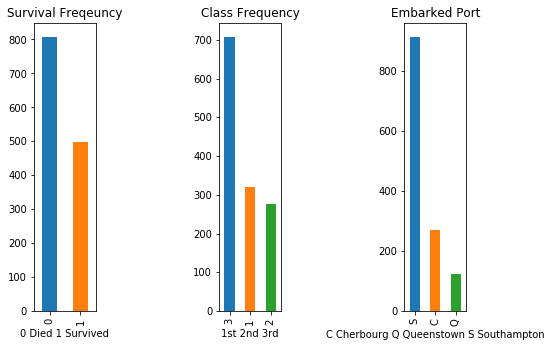

In [37]:
import matplotlib.pyplot as plt

plt.subplots_adjust(left=1, bottom=1, right=2, top=2, wspace=2, hspace=2)

plt.subplot(1, 3, 1)
df['Survived'].value_counts().plot(kind='bar')
plt.title('Survival Freqeuncy')
plt.xlabel('0 Died 1 Survived')

plt.subplot(1, 3, 2)
df['Pclass'].value_counts().plot(kind='bar')
plt.title('Class Frequency')
plt.xlabel('1st 2nd 3rd')

plt.subplot(1, 3, 3)
df['Embarked'].value_counts().plot(kind='bar')
plt.title('Embarked Port')
plt.xlabel('C Cherbourg Q Queenstown S Southampton')

The follwing can be observed:
* The majority of the passengers in the data did not seem to survive the accident according to the test and training data. 
* While the majority of passengers came as 3rd class, more 1st class passengers attended than 2nd class
* THe absolute majority of passengers came from the Cherbourg port compared to the other two (more than double Queenstown).

### Numerical Data (Box Plots)

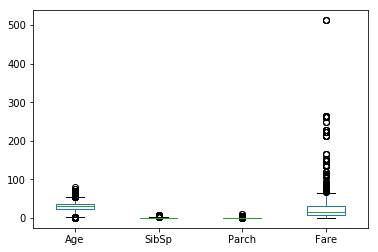

In [4]:
boxDf = df[['Age','SibSp','Parch','Fare']]
boxDf.plot(kind='box')

The box plot of non categorical fields shows an issue with the scale variance between the different values. This scale difference makes it difficult to compare the data spread and location between different variables. Hence, scaling is necesarry. 

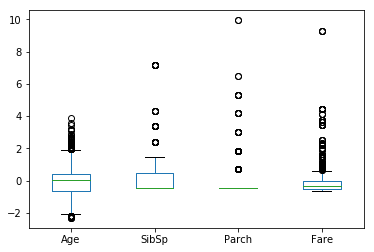

In [11]:
import sklearn.preprocessing as pre
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper([(boxDf.columns, pre.StandardScaler())])
scaledFeatures = mapper.fit_transform(boxDf.copy(), len(boxDf.columns))
sBoxDf = pd.DataFrame(scaledFeatures, index=boxDf.index, columns=boxDf.columns)
sBoxDf.plot(kind='Box')

Looking at the data we can see that:
* Fare data is tightly clustered with a lot of outliers. This probably because the majority of fares are clustered together and the more luxrious fares are unpopular or too expensive 
* Age distribution seems to fairly well spread out, but with a couple of outliers at the highest ages.
* Number of parents or children abroad seems to average around 0 in the scale with little to no range, meaning that the average is very low and very common. The outliers for the high values suggests not many family came to the trip.
* The number of sibilings or spouses seems to have a similar average than parents or children, but higher ranges and fewer outliers suggests that sibilings/spouses number above the average are more common than families above the average.